In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _tconfint_generic
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('2018.csv', encoding='cp1251')

In [ ]:
data.head(3)

,Число бракованных листов,Скорость прокатки,Марка стали
0,3,3.8,A
1,3,3.8,B
2,3,4.8,B


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Число бракованных листов  237 non-null    int64  
 1   Скорость прокатки         237 non-null    float64
 2   Марка стали               237 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.7+ KB


Предобработка данных не требуется - пропусков нет, тип данных корректный, однако переименуем названия столбцов для удобства дальнейшего анализа.

In [ ]:
data.columns = ['lists_count', 'speed', 'marks']

In [ ]:
data.head(1)

,lists_count,speed,marks
0,3,3.8,A


## Гипотеза №1:<br>
Более 3 бракованных листов на партию выходит значимо чаще для стали марки А, чем для стали марки B.

Функция для подсчета количества партий с браком (>3), всего партий конкретной марки и процентное соотношений брака к общему количеству.

In [ ]:
def analize_part_count(marks):
  broke = data.query('lists_count > 3 & marks == @marks')['marks'].count()
  all = data.query('marks == @marks')['marks'].count()
  percent = round(
      data.query('lists_count > 3 & marks == @marks')['marks'].count()/
      data.query('marks == "A"')['marks'].count(), 3)*100
  
  print(f"Количество партий стали марки \'{marks}\' с более чем 3 бракованными листами:\n", broke)
  print(f"Всего партий стали марки \'{marks}\':\n", all)
  print(f"Процент партий марки \'{marks}\' с более чем 3 бракованными листами:\n", percent, "%")

In [ ]:
analize_part_count("A")

Количество партий стали марки 'A' с более чем 3 бракованными листами:
 53
Всего партий стали марки 'A':
 139
Процент партий марки 'A' с более чем 3 бракованными листами:
 38.1 %


In [ ]:
analize_part_count("B")

Количество партий стали марки 'B' с более чем 3 бракованными листами:
 44
Всего партий стали марки 'B':
 98
Процент партий марки 'B' с более чем 3 бракованными листами:
 31.7 %


На первый взгляд, количество **партий** стали марки "А" с более чем 3 бракованными листами и в количественном (53/44), и в процентном (38.1/31.7) соотношении больше, нежели партий марки "В". <br>

Проведем анализ с учетом количества бракованных **листов** в каждой партии:

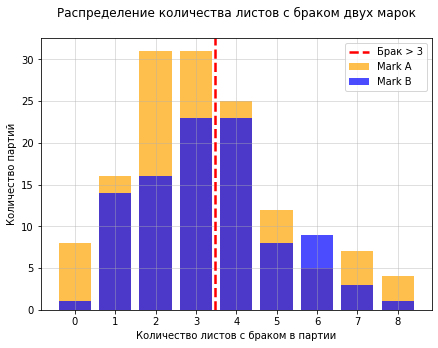

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(data.query('marks == "A"').groupby('lists_count')['marks'].count().index,
        data.query('marks == "A"').groupby('lists_count')['marks'].count(),
        color='orange', alpha=0.7, label="Mark A")
plt.bar(data.query('marks == "B"').groupby('lists_count')['marks'].count().index,
        data.query('marks == "B"').groupby('lists_count')['marks'].count(),
        color='b', alpha=0.7, label="Mark B")
plt.xticks(range(0,9))
plt.axvline(x=3.48, color='r',linewidth=2.5, label="Брак > 3", linestyle = '--')
plt.title("Распределение количества листов с браком двух марок\n")
plt.xlabel('Количество листов с браком в партии')
plt.ylabel('Количество партий')
plt.legend()
plt.grid(alpha=.5)

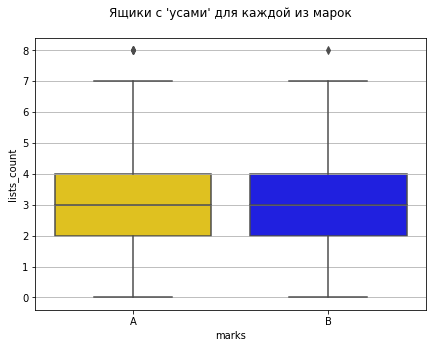

In [ ]:
plt.figure(figsize=(7,5))
plt.grid()
plt.title("Ящики с 'усами' для каждой из марок\n")
sns.boxplot(x="marks", y="lists_count", data=data, palette=['gold','b'])

Несмотря на то, что в процентном соотношении партий стали "А" с бракованными листами (которых > 3) больше, чем партий стали "B", визуально это не так очевидно.
Чтобы окончательно убедиться в этом воспользуемся средним доверительным интервалом:

In [ ]:
#Функция подсчета среднего доверительного интервала
def mean_confidence_interval(part): 
  interval_95 = _tconfint_generic(part.mean(), part.std(ddof=1)/np.sqrt(len(part)), 
                                  len(part)-1, 0.05, 'two-sided') 
  interval_90 = _tconfint_generic(part.mean(), part.std(ddof=1)/np.sqrt(len(part)), 
                                  len(part)-1, 0.1, 'two-sided')
  return {'interval_95': interval_95, 'interval_90': interval_90, 'mean': part.mean()}

In [ ]:
mean_confidence_interval(data.query('lists_count > 3 & marks == "A"')['lists_count'])

{'interval_90': (4.805042256187025, 5.421372838152599),
 'interval_95': (4.743957591263485, 5.482457503076138),
 'mean': 5.113207547169812}

In [ ]:
mean_confidence_interval(data.query('lists_count > 3 & marks == "B"')['lists_count'])

{'interval_90': (4.606515208023005, 5.166212064704268),
 'interval_95': (4.550644180687348, 5.2220830920399255),
 'mean': 4.886363636363637}

Видно, что партий стали "А" с более чем 3 бракованными листами больше, нежели аналогичных партий стали "В" (доверительные 90% и 95% средние интервалы для стали "А" больше, чем для стали "В").

## Гипотеза №2:<br>
При скоростях прокатки более 4 м/с свыше 3 бракованных листов стали на партию выходит значимо чаще, чем при меньших скоростях прокатки. 

In [ ]:
a =  data.query('speed > 4 and lists_count > 3')['marks'].count()
print("Количество партий с более чем 3 бракованными листами и скоростью прокатки более 4 м/с:\n", a)

Количество партий с более чем 3 бракованными листами и скоростью прокатки более 4 м/с:
 74


In [ ]:
b = data.query('speed <= 4 and lists_count > 3')['marks'].count()
print("Количество партий с более чем 3 бракованными листами и скоростью прокатки не более 4 м/с:\n", b)

Количество партий с более чем 3 бракованными листами и скоростью прокатки не более 4 м/с:
 23


In [ ]:
c = data.query('speed > 4')['marks'].count()
print("Общее количество партий со скоростью прокатки более 4 м/c:\n", c)

Общее количество партий со скоростью прокатки более 4 м/c:
 179


In [ ]:
d = data.query('speed <= 4')['marks'].count()
print("Общее количество партий со скоростью не более 4 м/c:\n", d)

Общее количество партий со скоростью не более 4 м/c:
 58


In [ ]:
print("соотношение партий с более чем 3 бракованными листами при скорости более 4 м/c к общему:\n", round(a/c, 3))

соотношение партий с более чем 3 бракованными листами при скорости более 4 м/c к общему:
 0.413


In [ ]:
print("соотношение партий с более чем 3 бракованными листами при скорости НЕ более 4 м/c к общему:\n", round(b/d, 3))

соотношение партий с более чем 3 бракованными листами при скорости НЕ более 4 м/c к общему:
 0.397


Даже при поверхностном анализе видно, что при скорости более 4 м/c, процент брака выше. Проверим теорию более тщательно:

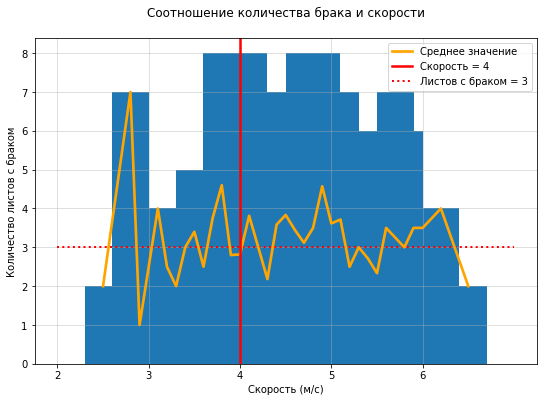

In [ ]:
plt.figure(figsize=(9,6))
plt.bar(data['speed'], data['lists_count'], width=0.4, )
plt.plot(data.groupby('speed')['lists_count'].mean(), color='orange', linewidth=2.7, label="Среднее значение")
plt.xticks(range(2,7))
plt.axvline(x=4, color='r',linewidth=2.5, label="Скорость = 4")
plt.hlines(xmin=2, xmax=7, y=3, color='r',linewidth=2, label="Листов с браком = 3", linestyle = ':')
plt.title("Соотношение количества брака и скорости\n")
plt.xlabel('Cкорость (м/c)')
plt.ylabel('Количество листов с браком')
plt.legend()
plt.grid(alpha=.5)

Даже с учетом "выброса" количества листов с браком при скорости равной ~2.7 м/c видно, что при скоростях > 4 м/c количество брака выше.

Проверим средний доверительный интервал при скоростях до и после 4 м/c:

In [ ]:
# меньше 4 м/c
mean_confidence_interval(data.query('speed <= 4 and lists_count > 3')['lists_count'])

{'interval_90': (4.383112007929223, 5.356018426853386),
 'interval_95': (4.282053634235697, 5.457076800546912),
 'mean': 4.869565217391305}

In [ ]:
# больше 4 м/c
mean_confidence_interval(data.query('speed > 4 and lists_count > 3')['lists_count'])

{'interval_90': (4.820919701799496, 5.287188406308613),
 'interval_95': (4.775160208256021, 5.332947899852088),
 'mean': 5.054054054054054}

Хоть среднее значение при скоростях < 4 м/c меньше среднего значения при скоростях > 4 м/c (4.87 и 5.05 соответственно), однако оба доверительных интервала (90 и 95%) при скоростях больших 4 м/c находятся внутри аналогичных интервалов для партий со скоростью менее 4 м/c, что не позволяет однозначно утверждать о том, что гипотеза верна.<br>

Воспользуемся еще одним способом - проверим равенство средних двух совокупностей с помощью метода **scipy.stats.ttest_ind()**.<br>
Сформулируем нулевую и альтернативные гипотезы:<br>
**Нулевая гипотеза:** среднее количество бракованных листов в партиях (где бракованных листов >3) со скоростю менее и более 4 м/c равны.<br>
**Альтернативная гипотеза:** среднее количество бракованных листов в партиях (где бракованных листов >3) со скоростю менее и более 4 м/c не равны.<br>

In [ ]:
alpha = 0.01 # критический уровень статистической значимости

#Игры Экшен за последние 9 лет
less4 = data.query('speed <=4 and lists_count > 3')['lists_count']
#Игры Спорт за последние 9 лет
more4 = data.query('speed > 4 and lists_count > 3')['lists_count']

hypo_2 = st.ttest_ind(
    less4, 
    more4)
print('p-значение:', hypo_2.pvalue)

if (hypo_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось опровергнуть нулевую гипотезу")

p-значение: 0.535079103101503
Не получилось опровергнуть нулевую гипотезу


Тот факт, что гипотезу о равенстве средних не удалость опровергнуть не означает, что она верна, однако и доказать её исходя из данной выборки не получилось.

*Прим. - Для проверки гипотез применили метод scipy.stats.ttest_ind(), поскольку сравнивались средние двух независимых совокупностей по взятым из них выборкам (данные за 2018 год могут быть неполными).*